# Trabajo Fin de Máster
## Antonio Blasco Navarro

#Propagación y predicción de la COVID-19

Este archivo cuenta con todo el código necesario para conseguir los objetivos planteados del TFM. Se quiere conseguir:

*   Clusterizar zonas básicas de Salud
*   Crear un modelo capaz de predecir casos de COVID-19

Para ello, lo primero es crear el DataFrame final con el que se va a realizar el estudio.



## Creación del DataFrame

Tras haber creado la zona de estudio (Madrid.shp) y haber seleccionado todas las características necesarias en formato .geojson, se puede realizar el estudio de clustering y la modelización de casos COVID en cada zona. Para ello primeramente se tiene que crear el DataFrame final, es decir, contabilizar todas las características respecto todos los polígonos del archivo Madrid.shp.

Primeramente, se cargan las librerias necesarias para realizar el análisis.

In [ ]:
#Librerias necesarias

#Geográficas

!pip install geopandas
!pip install descartes
!pip install geojson

import geopandas as gpd
import geojson
import fiona
from shapely.geometry import Point

from shapely.geometry.geo import asShape

#DataFrame

import pandas as pd
import numpy as np

#Clusters
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Pintar
import matplotlib.pyplot as plt

#Train-test
from sklearn.model_selection import train_test_split

#Modelo
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
import multiprocessing

#Tipos de modelos e hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model


     |████████████████████████████████| 994 kB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.6 MB 36.8 MB/s 


Se comprueba que ambas librerias geográficas se han cargado correctamente.

In [ ]:
import sys
['geopandas' in sys.modules, 'fiona' in sys.modules]

[True, True]

Recordar subir ahora todos los archivos necesarios. Estos son 


*   Los archivos *shape*
        Madrid.shp
        Madrid.shx
*   Los archivos *geojson*
        bar.geojson
        guest_house.geojson
        hotel.geojson
        metro.geojson
        museum.geojson
        pub.geojson
        restaurant.geojson
        school.geojson




A continuación se van a crear dos funciones. Una que tenga como input la forma .shp y de output saque la geometria del polígono y la envoltura del shape.

In [ ]:
# Cargar zona
def loadShape(madrid_shp):
	'''
	'''
	geometries = {}
	envelopes = {}
	cell_to_prov = {}
	for geo_object in fiona.open(madrid_shp):
		geometry = asShape( geo_object['geometry'] )
		geo_id = geo_object['properties']['DS_NOMBRE']
		geometries[geo_id] = geometry
		envelopes[geo_id] = geometry.envelope

	return geometries, envelopes

Esta segunda función comprueba si el punto está dentro de la zona de estudio, y en caso de estarlo, indica en la zona en la cual se encuentra.

In [ ]:
#Comprobar zonas
def checkCoords(lat, lon, geometries, envelopes, contour_geometries, contour_envelopes):
  '''
	'''
  xy_coords = ( lon, lat )
  point = Point( xy_coords )
  assign_zone = None

  for contour_zone in contour_geometries:
    if contour_envelopes[contour_zone].contains( point ):
      if contour_geometries[contour_zone].contains( point ):
        for zone in geometries:
          if geometries[zone].contains( point ):
            assign_zone = zone
            return assign_zone

  return assign_zone

Las dos funciones creadas se emplean para el estudio de nuestro caso con nuestros atributos correspondientes.

In [ ]:
madrid_contour_shp = 'contour_4326/contour.shp' #Importante que las coordenadas guardadas de QGIS estén en formato 4326
contour_geometries, contour_envelopes = loadShape( madrid_contour_shp) #Se emplea la función creada previamente, en este caso para la envoltura
madrid_shp = 'madrid_4326/Madrid.shp'
geometries, envelopes = loadShape( madrid_shp) #Se hace lo mismo para el polígono
print ('Shapes Loaded')

Shapes Loaded


EL siguiente código genera el .csv deseado. Por tener que comprobar muchos puntos dentro de cada polígono, estas líneas de código requieren bastante tiempo.



In [ ]:
#Atributos a estudiar en cada polígono
study_objects = ['airbnb','bar','guest_house','hotel','metro','museum','pub','restaurant','school']

#Nombre del output
output_path = 'madrid_attributes.csv'

with open(output_path, 'w') as output: #Se abre el archivo de salida
  output.write('zone|type|value\n')
  output_dict = {} #Se crea diccionario
  for study_object in study_objects: #Para cada atributo
    input_data_path = '{}.geojson'.format(study_object)
    with open(input_data_path, 'r') as f:
      gj = geojson.load(f)
      for object in gj['features']:
        [lon, lat] = object['geometry']['coordinates'] #Se cogen las coordenadas y se dividen en latitud y longitud
        zone = checkCoords(lat, lon, geometries, envelopes, contour_geometries, contour_envelopes) #Se comprueba dentro de que polígono está
        if zone: #Si se encuentra en una zona
          output_dict.setdefault(zone, {})
          output_dict[zone].setdefault(study_object, 0)
          output_dict[zone][study_object] += 1 #Se suma 1 al diccionario zona dentro del atributo
  for zone in output_dict:
    for study_object in output_dict[zone]:
      value = output_dict[zone][study_object]
      output.write('{}|{}|{}\n'.format(zone, study_object, value)) #Una vez finalizado el proceso, se exporta el archivo en formato .csv

Tras 24 minutos de espera, se ha generado el archivo final .csv. Este archivo contiene los nombres, la clase y el número de veces que se tiene esa clase en la zona. Estos datos se han exportado al EXCEL.

## Depuración de los datos

Tras obtener el EXCEL completo con todas las variables descriptivas, se depura los datos para obtener el mejor dataset posible que mejores resultados prediga.

In [ ]:
df = pd.read_excel("variable_descriptivas.xlsx")
print(df)

      Id   Zona Básica Salud     Distrito  ...  Museo  Restaurante  Pub
0      0            Abrantes  Carabanchel  ...      0            0    0
1      1             Acacias   Arganzuela  ...      0            9    3
2      2             Adelfas       Retiro  ...      0           15    5
3      3             Alameda       Centro  ...      1           99   23
4      4    Alameda de Osuna      Barajas  ...      0           25    2
..   ...                 ...          ...  ...    ...          ...  ...
129  129  Vinateros - Torito    Moratalaz  ...      0            1    8
130  130    Virgen de Begoña   Fuencarral  ...      0           13   11
131  131  Virgen del Cortijo    Hortaleza  ...      0           23    3
132  132        Vista Alegre  Carabanchel  ...      0           14   15
133  133               Zofío        Usera  ...      0            2    0

[134 rows x 14 columns]


In [ ]:
df.dtypes

Id                      int64
Zona Básica Salud      object
Distrito               object
Superficie (en m2)      int64
Población             float64
Airbnb                  int64
Bar                     int64
Colegio                 int64
Hostal                  int64
Hotel                   int64
Metro                   int64
Museo                   int64
Restaurante             int64
Pub                     int64
dtype: object

Se escoge como índice el nombre de la Zona Básica de Salud.

In [ ]:
df = df.set_index('Zona Básica Salud')
df

,Id,Distrito,Superficie (en m2),Población,Airbnb,Bar,Colegio,Hostal,Hotel,Metro,Museo,Restaurante,Pub
Zona Básica Salud,,,,,,,,,,,,,
Abrantes,0,Carabanchel,1571624,31934.006884,46,0,5,0,0,2,0,0,0
Acacias,1,Arganzuela,771573,19449.998748,61,4,3,0,1,1,0,9,3
Adelfas,2,Retiro,854811,29468.997564,136,3,0,0,0,1,0,15,5
Alameda,3,Centro,547598,21874.004543,1093,47,2,12,13,1,1,99,23
Alameda de Osuna,4,Barajas,35138446,29512.995653,76,7,6,0,3,5,0,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vinateros - Torito,129,Moratalaz,1062147,31247.004697,44,7,2,0,0,1,0,1,8
Virgen de Begoña,130,Fuencarral,1334974,9798.003217,35,1,3,0,1,0,0,13,11
Virgen del Cortijo,131,Hortaleza,1501550,14185.996190,53,0,0,0,0,0,0,23,3


### Id

Hay que eliminar la columna ID, ya que se ha seleccionado el nombre como Id de cada fila.

In [ ]:
df = df.drop(['Id'], axis=1)
print(df)

                       Distrito  Superficie (en m2)  ...  Restaurante  Pub
Zona Básica Salud                                    ...                  
Abrantes            Carabanchel             1571624  ...            0    0
Acacias              Arganzuela              771573  ...            9    3
Adelfas                  Retiro              854811  ...           15    5
Alameda                  Centro              547598  ...           99   23
Alameda de Osuna        Barajas            35138446  ...           25    2
...                         ...                 ...  ...          ...  ...
Vinateros - Torito    Moratalaz             1062147  ...            1    8
Virgen de Begoña     Fuencarral             1334974  ...           13   11
Virgen del Cortijo    Hortaleza             1501550  ...           23    3
Vista Alegre        Carabanchel             1399449  ...           14   15
Zofío                     Usera             1871149  ...            2    0

[134 rows x 12 columns]


### Población

Como se menciona en la memoria del TFM, la población se ha calculado mediante unos proporciones de habitantes, por ello que se hayan obtenido números no naturales. Por ello, para obtener valores int y no float, se redondea:

In [ ]:
df['Población'] = df['Población'].round(0).astype(int)
print(df)

                       Distrito  Superficie (en m2)  ...  Restaurante  Pub
Zona Básica Salud                                    ...                  
Abrantes            Carabanchel             1571624  ...            0    0
Acacias              Arganzuela              771573  ...            9    3
Adelfas                  Retiro              854811  ...           15    5
Alameda                  Centro              547598  ...           99   23
Alameda de Osuna        Barajas            35138446  ...           25    2
...                         ...                 ...  ...          ...  ...
Vinateros - Torito    Moratalaz             1062147  ...            1    8
Virgen de Begoña     Fuencarral             1334974  ...           13   11
Virgen del Cortijo    Hortaleza             1501550  ...           23    3
Vista Alegre        Carabanchel             1399449  ...           14   15
Zofío                     Usera             1871149  ...            2    0

[134 rows x 12 columns]


### Distrito

Hay que categorizar los 21 distritos de Madrid, parra así trabajar con variables numéricas.

In [ ]:
df['Distrito'] = df['Distrito'].map( {'Arganzuela': 1, 'Barajas': 2, 'Carabanchel': 3,
                                      'Centro': 4, 'Chamartín': 5, 'Chamberí': 6,
                                      'Ciudad Lineal': 7, 'Fuencarral': 8, 'Hortaleza': 9,
                                      'Latina': 10, 'Moncloa': 11, 'Moratalaz': 12,
                                      'Puente de Vallecas': 13, 'Retiro': 14, 'Salamanca': 15,
                                      'San Blas': 16, 'Tetuan': 17, 'Usera': 18,
                                      'Vicálvaro': 19, 'Villa de Vallecas': 20, 'Villaverde': 21} ).astype(int)
                                    
print(df)

                    Distrito  Superficie (en m2)  ...  Restaurante  Pub
Zona Básica Salud                                 ...                  
Abrantes                   3             1571624  ...            0    0
Acacias                    1              771573  ...            9    3
Adelfas                   14              854811  ...           15    5
Alameda                    4              547598  ...           99   23
Alameda de Osuna           2            35138446  ...           25    2
...                      ...                 ...  ...          ...  ...
Vinateros - Torito        12             1062147  ...            1    8
Virgen de Begoña           8             1334974  ...           13   11
Virgen del Cortijo         9             1501550  ...           23    3
Vista Alegre               3             1399449  ...           14   15
Zofío                     18             1871149  ...            2    0

[134 rows x 12 columns]


In [ ]:
df.dtypes

Distrito              int64
Superficie (en m2)    int64
Población             int64
Airbnb                int64
Bar                   int64
Colegio               int64
Hostal                int64
Hotel                 int64
Metro                 int64
Museo                 int64
Restaurante           int64
Pub                   int64
dtype: object

Se ha depurado el dataset para obtener finalmente todas las variables del tipo numérico como se quiere obtener. A continuación se comprueba la proporción de valores en cada una de las variables.

## Porcentajes en cada clase

A cotinuación se comprueba la cantidad de valores en cada una de las variables geográficas. Se sabe que si una variable tiene más de un 95% de valores en una categoria se debería quitar, pues no aporta mucha información

In [ ]:
lista = [df.Airbnb.value_counts(normalize=True).head(2),
 df.Bar.value_counts(normalize=True).head(2),
 df.Colegio.value_counts(normalize=True).head(2),
 df.Hostal.value_counts(normalize=True).head(2),
 df.Hotel.value_counts(normalize=True).head(2),
 df.Metro.value_counts(normalize=True).head(2),
 df.Museo.value_counts(normalize=True).head(2),
 df.Restaurante.value_counts(normalize=True).head(2),
 df.Pub.value_counts(normalize=True).head(2)]

for x in lista:
  print (x*100)

15    2.238806
19    2.238806
Name: Airbnb, dtype: float64
0    18.656716
2    13.432836
Name: Bar, dtype: float64
0    20.895522
1    17.910448
Name: Colegio, dtype: float64
0    88.059701
1     3.731343
Name: Hostal, dtype: float64
0    67.910448
1    13.432836
Name: Hotel, dtype: float64
1    34.328358
0    26.119403
Name: Metro, dtype: float64
0    85.820896
1     9.701493
Name: Museo, dtype: float64
0    8.208955
2    8.208955
Name: Restaurante, dtype: float64
0    25.373134
1    13.432836
Name: Pub, dtype: float64


Ningún valor supera el 90%, por lo que suponemos que no hay problemas con las variables. Al estar creado el dataset por nosotros, se sabe que es un dataset limpio, sin valores que falten o valores erróneos. Lo que sí se deberá comprobar a continuación es la correlación entre las variables y la varianza de cada una de las variables.

## VIF

Como se sabe de algunos módulos vistos en clase, se quiere evitar la alta correlación entre las variables. Se quiere que las variables de observación expliquen en la mayor medida de lo posible datos nuevos que sean independientes de los demás, es decir, se quiere tener una baja colinealidad entre las variables. De este modo, cada variable explica una cosa acerca del modelo que es independiente de la otra. Si se tiene una alta colinealidad entre 2 variables, se tiene que esas 2 variables explican cosas similares acerca del modelo, lo cual es redundante y una de esas variables se debería eliminar.

Para lograr este objetivo, se emplean las técnicas aprendidas durante los módulos, es decir, se aplica el criterio del valor de VIF.

In [ ]:
# Función para calcular el VIF

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

In [ ]:
#Se calcula el VIF para nuestro dataset

calculateVIF(df)

,Distrito,Superficie (en m2),Población,Airbnb,Bar,Colegio,Hotel,Metro,Museo,Restaurante,Pub
VIF,1.204269,1.01817,1.339593,12.086118,7.6673,1.411802,11.345893,1.837724,7.680042,16.520695,2.364697


Se comprueba que hay muchas variables que tienen un VIF elevado. Estas hay que eliminarlas, ya que la alta correlación entre variables puede dar problemas. Se considera un VIF elevado cuando los valores sobrepasan el umbral 5. Para decidir que variables eliminar, se tendrán en cuenta dos aspectos. Por un lado el valor del VIF y por otro lado el valor de 0s de las variables. Para este segundo punto, se vuelve a consultar el código realizado al principio del estudio.

In [ ]:
lista = [df.Airbnb.value_counts(normalize=True).head(2),
 df.Bar.value_counts(normalize=True).head(2),
 df.Colegio.value_counts(normalize=True).head(2),
 df.Hostal.value_counts(normalize=True).head(2),
 df.Hotel.value_counts(normalize=True).head(2),
 df.Metro.value_counts(normalize=True).head(2),
 df.Museo.value_counts(normalize=True).head(2),
 df.Restaurante.value_counts(normalize=True).head(2),
 df.Pub.value_counts(normalize=True).head(2)]

for x in lista:
  print (x*100)

15    2.238806
19    2.238806
Name: Airbnb, dtype: float64
0    18.656716
2    13.432836
Name: Bar, dtype: float64
0    20.895522
1    17.910448
Name: Colegio, dtype: float64
0    88.059701
1     3.731343
Name: Hostal, dtype: float64
0    67.910448
1    13.432836
Name: Hotel, dtype: float64
1    34.328358
0    26.119403
Name: Metro, dtype: float64
0    85.820896
1     9.701493
Name: Museo, dtype: float64
0    8.208955
2    8.208955
Name: Restaurante, dtype: float64
0    25.373134
1    13.432836
Name: Pub, dtype: float64


Hay un 88% de 0s en hostales y además tiene un VIF de 18, por lo que se elimina del dataset y se comprueba el VIF resultante de las otras variables.

In [ ]:
df.drop(columns = ['Hostal'], inplace =True)
calculateVIF(df)

,Distrito,Superficie (en m2),Población,Airbnb,Bar,Colegio,Hotel,Metro,Museo,Restaurante,Pub
VIF,1.204269,1.01817,1.339593,12.086118,7.6673,1.411802,11.345893,1.837724,7.680042,16.520695,2.364697


Sgiuiendo el mismo criterio que previamente, se elimina la variable *Museo* por tener un 85% de 0s.

In [ ]:
df.drop(columns = ['Museo'], inplace =True)
calculateVIF(df)

,Distrito,Superficie (en m2),Población,Airbnb,Bar,Colegio,Hotel,Metro,Restaurante,Pub
VIF,1.204033,1.017995,1.339575,11.612117,7.21979,1.348259,6.749068,1.787635,16.068519,2.318699


El VIF entre las variables sigue siendo muy elevado, por lo que se decide eliminar la variable *Restaurante* por su VIF elevado con un valor superior a 16.

In [ ]:
df.drop(columns = ['Restaurante'], inplace =True)
calculateVIF(df)

,Distrito,Superficie (en m2),Población,Airbnb,Bar,Colegio,Hotel,Metro,Pub
VIF,1.192038,1.01387,1.331994,10.68442,5.819389,1.346768,3.967459,1.696501,2.192342


Volviendo a observar la cantidad de 0s, se elimina la variable *Hotel* por tener muchos 0s. Se comprueba el VIF resultante.

In [ ]:
df.drop(columns = ['Hotel'], inplace =True)
calculateVIF(df)

,Distrito,Superficie (en m2),Población,Airbnb,Bar,Colegio,Metro,Pub
VIF,1.173084,1.010896,1.314464,5.681975,5.381398,1.312591,1.615387,2.16213


Airbnb y Bar tienen valores muy elevados ambos, sin embargo, por contener Airbnb más valores diferentes, se decide eliminar la variable *Bar*. Se supone que la variable Airbnb puede aportar más información que la variable Bar.

In [ ]:
df.drop(columns = ['Bar'], inplace =True)
calculateVIF(df)

,Distrito,Superficie (en m2),Población,Airbnb,Colegio,Metro,Pub
VIF,1.172195,1.01066,1.278523,2.15699,1.231989,1.554662,2.0747


El VIF entre todas las variables es muy bajo, por lo que se puede trabajar con este dataset, ya que las columnas tienen una baja correlación entre si. Finalmente, de las coordenadas geográficas, únicamente se han escogido:


*   Airbnb
*   Colegio
*   Metro
*   Pub

In [ ]:
df.shape[1]

7

En este momento se tiene 7 variables explicativas. Comprobemos la Varianza de las variables. 

### Varianza baja

Además del estudio realizado del VIF, se quiere un dataset con variables que contengan una varianza elevada. Por ello, se van a eliminar aquellas variables con una varianza demasiado baja, pues esto puede causar un problema cuando el conjunto se divida en *train* y *test*.

In [ ]:
var_th = VarianceThreshold(threshold = 0.30)
df_var = var_th.fit_transform(df)

Veamos que variables se mantienen igual

In [ ]:
df_var.shape[1]

7

Se conservan las 7 variables del modelo, pues la varianza no dará problemas.
Finalmente se ha terminado con el análisis del Dataset. Se ha comprobado que es un dataset válido para poder trabajar con él. Por ello, a continuación, se realizarán los dos estudios principales. Por un lado se clusteriza las zonas básicas de Salud. Por otro, se creará un modelo capaz de modelar la COVID-19 en cada unas de las zonas básicas de Salud.

## Clustering

Tras la depuración de los datos, ya se puede clusterizar las diferentes zonas básicas de Salud.

### Matriz de distancias

Se halla a continuación la matriz de distancias entre todos los individuos. Para ello, primeramente hay que estandarizar los datos para que todas las variables sean igual de cualitativas.

In [ ]:
datos_escalados = scale(X=df, axis=0, with_mean=True, with_std=True) 
datos_escalados = pd.DataFrame(datos_escalados, columns=df.columns, index=df.index)
datos_escalados.head(4)

,Distrito,Superficie (en m2),Población,Airbnb,Colegio,Metro,Pub
Zona Básica Salud,,,,,,,
Abrantes,-1.329246,-0.172085,0.711554,-0.307332,1.017710,0.390174,-0.713189
Acacias,-1.675108,-0.218910,-0.545417,-0.261407,0.146316,-0.326035,-0.268000
Adelfas,0.572995,-0.214038,0.463362,-0.031782,-1.160775,-0.326035,0.028793
Alameda,-1.156315,-0.232019,-0.301353,2.898233,-0.289381,-0.326035,2.699931


Matriz de distancias

In [ ]:
#Cálculo de distancias

distancias = pairwise_distances(
                X      = datos_escalados,
                metric ='euclidean'
             )

#Como DataFrame

distancias = pd.DataFrame(
                distancias,
                columns=datos_escalados.index,
                index = datos_escalados.index
            )


#Mostras primeras 4 filas y columnas
distancias.iloc[:4,:4]

Zona Básica Salud,Abrantes,Acacias,Adelfas,Alameda
Zona Básica Salud,,,,
Abrantes,0.000000,1.781678e+00,3.093072,5.020553
Acacias,1.781678,2.980232e-08,2.814414,4.394389
Adelfas,3.093072,2.814414e+00,0.000000,4.478271
Alameda,5.020553,4.394389e+00,4.478271,0.000000


Una vez creada la matriz de distancias, se puede crear un vector ordenado por mínimas distancias

In [ ]:
#Descartamos primero la diagonal superior para evitar problemas

# Se descarta la diagonal superior de la matriz

distancias = pairwise_distances(
                X      = datos_escalados,
                metric ='euclidean'
             )

distancias[np.triu_indices(n=distancias.shape[0])] = np.nan

#Lo demás se realiza igual

distancias = pd.DataFrame(
                distancias,
                columns=datos_escalados.index,
                index = datos_escalados.index
            )

#Se ordena de menor a mayor en forma de lista y decidimos que nos muestre, por ejemplo, los 3 primeros

distancias.melt(ignore_index=False, var_name="zona_básica_2", value_name='distancia') \
    .rename_axis("zona_básica_1") \
    .reset_index() \
    .dropna() \
    .sort_values('distancia') \
    .head(3)

,zona_básica_1,zona_básica_2,distancia
3052,Rafael Alberti,Campo de la Paloma,0.118943
7481,San Isidro,Guayaba,0.282083
1449,San Diego,Ángela Uriarte,0.321270


Nos muestra los *n* distritos más comunes, en este caso los 3 más parecidos son: 


*   Rafael Alberti - Campo de la Paloma
*   San Isidro - Guayaba
*   San Diego - Ángela Uriarte



### Número de clusteres óptimo

Como se trata de un problema de cluster no supervisado, no se sabe cual es la cantidad de clusteres óptimo. Por ello, se aplican las técnicas más conocidas, la de *Elbow* y *Silhouette*, para conocer este número.

Para decidir ahora el grupo de clusters se emplea el método de Elbow:

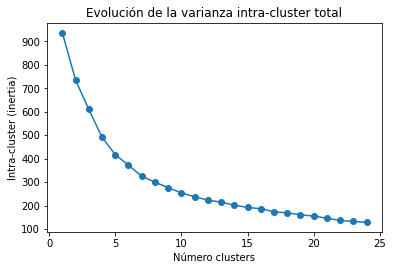

In [ ]:
#Método Elbow

range_n_clusters = range(1, 25) #Máximo 25 clusteres, no se quieren más
inertias = [] #Lista vacia en la cual se va insertando la evolucion de la varianza para cada número de cluster diferente

for n_clusters in range_n_clusters:
  # Para los 25 posibles clusteres, se van generando estos mediante el método de KMeans
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(datos_escalados)
    inertias.append(modelo_kmeans.inertia_)

#Figura que muestre la varianza intra-cluster de todos los modelos
#Se quiere buscar un momento en el cual la varianza deje de descender tan bruscamente.

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Cuesta con este método observar el punto en el que la varianza deja de descender tan rápidamente. A partir de aproximadamente 6 clusteres se podría considerar que la curva se empieza a aplanar un poco.

Veamoslo ahora con Silhouette el número óptimo de clusters que recomienda

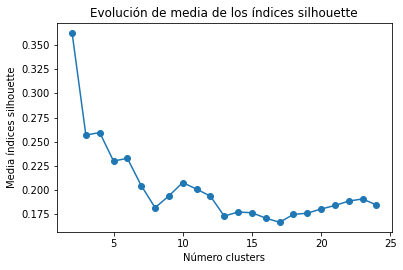

In [ ]:
# Método silhouette


#Del mismo modo, se selecciona un máximo de 25 clusters y se genera una lista vacia para ir añadiendo los valores
#En este caso, no se quiere la varianza sino la media de los índices
range_n_clusters = range(2, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(datos_escalados)
    silhouette_avg = silhouette_score(datos_escalados, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

#Se pintan a continuación los diferentes puntos
#Se busca un punto en el cual haya un pico
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Con el método Elbow no se llega a reconocer del todo bien. Con Silhouette se reconoce mejor. No se quieren seleccionar demasiados clusters, puesto que tampoco hay tantas variables descriptivas en el Dataset. Por lo tanto se opta por escoger **6** clusters por haber un pequeño pico mediante el método de Slhouette. Otras posibilidades podrían haber sido 4 o 10 clusters por haber picos en la gráfica de Silhouette. Sin embargo, por haber más de 130 zonas de salud, se ha considerado que 4 es un número muy bajo y se ha considerado que 10 es un número muy elevado, por ello se ha optado por escoger 6 clusters.



### Dividir las zonas básicas de salud en clusters.

Una vez se sabe que se quiere dividir el conjunto en 6 clusters, se aplican métodos no jerárquicos que dividan los 6 clusters de una forma lo más exacta posible, mediante el método de kMeans, aquel que va juntando formando los grupos mediante la distancia óptima entre los individuos. Veamos ahora los grupos de los diferentes clusters.

In [ ]:
km = KMeans(n_clusters=6).fit(datos_escalados)

cluster_map = pd.DataFrame()
cluster_map['zonas'] = datos_escalados.index.values
cluster_map['cluster'] = km.labels_

In [ ]:
cluster_map.head(20)

,zonas,cluster
0,Abrantes,0
1,Acacias,4
2,Adelfas,1
3,Alameda,2
4,Alameda de Osuna,0
5,Alcalá de Guadaira,1
6,Alcocer,1
7,Almendrales,1
8,Alpes,3
9,Andrés Mellado,0


Mediante un estudio de componentes principales, se podrían interpretar que variables representan mismas características y escoger las dos más significativas para representarlo gráficamente. Sin embargo, para el objetivo del trabajo esto no es de importancia, sino comparar las zonas de mismos clusters. Por ello, no se tratarán las Componentes Principales en este trabajo.

Este DataFrame se exporta como .csv

In [ ]:
cluster_map.to_csv ('Clusters.csv', header=True)

La división de los clusters y las principales conclusiones al respecto se discuten en la memoria del TFM.

Una vez finalizado el estudio de clustering, se crea el modelo mediante las técnicas de Machine Learning.

## Machine Learning

El objetivo de este apartado es generar un modelo capaz de predecir casos de COVID-19 en las diferentes zonas básicas de Salud. Para ello, se ha trabajado mediante la misma metodología que los módulos impartidos en durante el curso.

### Cargar Variable Objetivo

A continuación se va a crear el modelo para predecir covid en una cierta zona básica de Salud. Lo primero es cargar la variable objetivo.

In [ ]:
df_y = pd.read_excel("variable_objetivo.xlsx")
df_y = df_y.set_index('Zona Básica Salud')
df_y = df_y.drop(['Id'], axis=1)

df_y

,Casos confirmados totales (10 agosto)
Zona Básica Salud,
Abrantes,3889
Acacias,2175
Adelfas,3365
Alameda,2939
Alameda de Osuna,3327
...,...
Vinateros - Torito,4075
Virgen de Begoña,1365
Virgen del Cortijo,1875


## Crear el Modelo 

A continuación se va a crear el modelo capaz de predecir casos de COVID-19 en ciertas zonas básicas de Salud. Para ello se necesita un conjunto *train*, que será con el que el modelo entrene y el conjunto *test* para observar como de bien es capaz de predecir. Se ha decidido dividir los conjuntos en un 75% y 25% respectivamente.

En este caso se trata de un problema de *regresión* por ser la variable objetivo **continua**. Si fuese binaria, se trataría de un problema de *clasificación*.

### **Conjuntos Train/Test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df,
                                        df_y['Casos confirmados totales (10 agosto)'],
                                        train_size   = 0.75,
                                        random_state = 1234,
                                        shuffle = True
                                    )


A continuación se va a seleccionar el algoritmo que se va a emplear, mediante el objeto *estimator*. Este contiene los métodos *fit* para aprender sobre el conjunto train y el método *predict* para predecir los datos del conjunto test.

Además del propio modelo, cada algoritmo cuenta con sus propios hiperparámetros. Gracias a la función GridSearch se seleccionan aquellos parámetros que menor error asocien a los datos, con cuidado de no sobreentrenarlo y obtener overfitting.

## Tipos de Modelos

Para este apartado se van a emplear 5 tipos de modelos, cada uno con su GridSearch respectivamente. Se han escogido 5 tipos de modelos diferentes, posiblemente los más reconocidos, aunque se podrían haber escogido más modelos o haber buscado más hiperparámetros dentro de cada modelo usado. Los 5 modelos son

*   Regresión Lineal
*   Random Forest
*   Decision Tree
*   Gradient Boost
*   ARD


## Primer Modelo: Regresión Lineal

Lo primero que se hará, en los 5 casos, será buscar aquellos hiperparámetros que mejor estimen las observaciones.

In [ ]:
#Creación modelo

modelo_1 = LinearRegression()

In [ ]:
#Búsqueda mejores hiperparámetros

grid_param_1 = {
    'n_jobs': [1, 3, 5, 10, 100, 500]
}

#Model Grid para variables continuas

model_grid_1 = GridSearchCV(estimator=modelo_1,
                     param_grid=grid_param_1,
                     scoring='neg_root_mean_squared_error',
                     n_jobs     = multiprocessing.cpu_count() - 1,
                     cv=RepeatedKFold(n_splits = 5, n_repeats = 5),
                     verbose = 0
                     )

In [ ]:
model_grid_1.fit(X_train, y_train)

print(model_grid_1.best_params_)

{'n_jobs': 1}


Una vez se tienen los mejores resultados, se comprueban las predicciones y el error obtenido.

In [ ]:
#Modelo final ganador
modelofinal_1 = LinearRegression(n_jobs=1).fit(X_train, y_train)

predicciones_1 = modelofinal_1.predict(X_test)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones_1 = pd.DataFrame({'Casos' : y_test, 'prediccion' : predicciones_1})
df_predicciones_1.head(10)

,Casos,prediccion
Zona Básica Salud,,
Alcocer,2331,2355.961018
Virgen del Cortijo,1875,1831.029360
Pavones,2164,2104.932582
La Elipa,1948,1781.266237
Legazpi,3210,3514.184249
Martínez de la Riva,2787,2230.501021
Infanta Mercedes,1724,1872.661452
Justicia,2129,2021.825730
San Isidro,2496,2305.211992


Comprobamos ahora el error total

In [ ]:
rmse_1 = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones_1,
        squared = False
       )
rmse_1

364.60281407665434

Se obtiene un error de 364. Cuanto menor sea este número, mejor son las estimaciones.

Este mismo proceso se ha realizado para los siguientes 4 modelos.

## Random Forest

In [ ]:
#Creación modelo

modelo_2 = RandomForestRegressor()

In [ ]:
#Búsqueda mejores hiperparámetros

grid_param_2 = {
    'n_estimators': [100, 300, 700,100],
    'criterion': ['mse', 'mae'],
    'min_samples_split': [2,8,16,32]
}

#Model Grid para variables continuas

model_grid_2 = GridSearchCV(estimator=modelo_2,
                     param_grid=grid_param_2,
                     scoring='neg_root_mean_squared_error',
                     n_jobs     = multiprocessing.cpu_count() - 1,
                     cv=RepeatedKFold(n_splits = 5, n_repeats = 5),
                     verbose = 0
                     )

In [ ]:
model_grid_2.fit(X_train, y_train)

print(model_grid_2.best_params_)

{'criterion': 'mse', 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
#Modelo final ganador
modelofinal_2 = RandomForestRegressor(n_estimators=300, criterion='mse', min_samples_split=2).fit(X_train, y_train)

predicciones_2 = modelofinal_2.predict(X_test)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones_2 = pd.DataFrame({'Casos' : y_test, 'prediccion' : predicciones_2})
df_predicciones_2.head(10)

,Casos,prediccion
Zona Básica Salud,,
Alcocer,2331,2153.836667
Virgen del Cortijo,1875,1809.223333
Pavones,2164,2060.480000
La Elipa,1948,1732.746667
Legazpi,3210,3682.803333
Martínez de la Riva,2787,2219.426667
Infanta Mercedes,1724,1797.683333
Justicia,2129,1806.910000
San Isidro,2496,2362.203333


In [ ]:
rmse_2 = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones_2,
        squared = False
       )
rmse_2

320.6596688293142

## Decision Tree 

In [ ]:
#Creación modelo

modelo_3 = DecisionTreeRegressor()

In [ ]:
#Búsqueda mejores hiperparámetros

grid_param_3 = {
    'criterion': ['mse', 'friedman_mse','mae'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2,4,8,16,32],
    'max_depth': [1,2,4,8],
    'min_samples_leaf': [1,2,4,8]
}

#Model Grid para variables continuas

model_grid_3 = GridSearchCV(estimator=modelo_3,
                     param_grid=grid_param_3,
                     scoring='neg_root_mean_squared_error',
                     n_jobs     = multiprocessing.cpu_count() - 1,
                     cv=RepeatedKFold(n_splits = 5, n_repeats = 5),
                     verbose = 0
                     )

In [ ]:
model_grid_3.fit(X_train, y_train)

print(model_grid_3.best_params_)

{'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}


In [ ]:
#Modelo final ganador
modelofinal_3 = DecisionTreeRegressor(splitter='best', criterion='friedman_mse', min_samples_split=4, max_depth=4, min_samples_leaf=1).fit(X_train, y_train)

predicciones_3 = modelofinal_3.predict(X_test)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones_3 = pd.DataFrame({'Casos' : y_test, 'prediccion' : predicciones_3})
df_predicciones_3.head(10)

,Casos,prediccion
Zona Básica Salud,,
Alcocer,2331,2540.200000
Virgen del Cortijo,1875,1827.818182
Pavones,2164,1827.818182
La Elipa,1948,1827.818182
Legazpi,3210,3860.240000
Martínez de la Riva,2787,1827.818182
Infanta Mercedes,1724,1827.818182
Justicia,2129,1827.818182
San Isidro,2496,2540.200000


In [ ]:
rmse_3 = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones_3,
        squared = False
       )
rmse_3

402.17136038510546

## Gradient Boost

In [ ]:
#Creación modelo

modelo_4 = GradientBoostingRegressor()

In [ ]:
#Búsqueda mejores hiperparámetros

grid_param_4 = {
    'loss': ['ls', 'lad','huber','quantile'],
    'n_estimators': [50, 100, 300],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

#Model Grid para variables continuas

model_grid_4 = GridSearchCV(estimator=modelo_4,
                     param_grid=grid_param_4,
                     scoring='neg_root_mean_squared_error',
                     n_jobs     = multiprocessing.cpu_count() - 1,
                     cv=RepeatedKFold(n_splits = 5, n_repeats = 5),
                     verbose = 0
                     )

In [ ]:
model_grid_4.fit(X_train, y_train)

print(model_grid_4.best_params_)

{'criterion': 'mse', 'loss': 'huber', 'n_estimators': 300}


In [ ]:
#Modelo final ganador
modelofinal_4 = GradientBoostingRegressor(n_estimators=300, criterion='mse', loss='huber').fit(X_train, y_train)

predicciones_4 = modelofinal_4.predict(X_test)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones_4 = pd.DataFrame({'Casos' : y_test, 'prediccion' : predicciones_4})
df_predicciones_4.head(10)

,Casos,prediccion
Zona Básica Salud,,
Alcocer,2331,2208.345384
Virgen del Cortijo,1875,1725.604904
Pavones,2164,2120.968458
La Elipa,1948,1840.809934
Legazpi,3210,3734.092637
Martínez de la Riva,2787,2618.752558
Infanta Mercedes,1724,1885.838495
Justicia,2129,1863.264988
San Isidro,2496,2363.876828


In [ ]:
rmse_4 = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones_4,
        squared = False
       )
rmse_4

302.04221851435545

## ARD Regression



In [ ]:
#Creación modelo

modelo_5 = linear_model.ARDRegression()

In [ ]:
#Búsqueda mejores hiperparámetros

grid_param_5 = {
    'alpha_1': [1e-6, 1e-3],
    'alpha_2': [1e-6, 1e-3],
    'n_iter': [100, 300, 700],
    'threshold_lambda': [5000,10000,15000]
}
#Model Grid para variables continuas

model_grid_5 = GridSearchCV(estimator=modelo_5,
                     param_grid=grid_param_5,
                     scoring='neg_root_mean_squared_error',
                     n_jobs     = multiprocessing.cpu_count() - 1,
                     cv=RepeatedKFold(n_splits = 5, n_repeats = 5),
                     verbose = 0
                     )

In [ ]:
model_grid_5.fit(X_train, y_train)

print(model_grid_5.best_params_)

{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'n_iter': 300, 'threshold_lambda': 5000}


In [ ]:
#Modelo final ganador
modelofinal_5 = linear_model.ARDRegression(alpha_1=1e-06, alpha_2=1e-06, n_iter=300, threshold_lambda=5000).fit(X_train, y_train)

predicciones_5 = modelofinal_5.predict(X_test)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones_5 = pd.DataFrame({'Casos' : y_test, 'prediccion' : predicciones_5})
df_predicciones_5.head(10)

,Casos,prediccion
Zona Básica Salud,,
Alcocer,2331,2225.324302
Virgen del Cortijo,1875,1841.725384
Pavones,2164,2095.908487
La Elipa,1948,1819.952830
Legazpi,3210,3548.744930
Martínez de la Riva,2787,2200.539496
Infanta Mercedes,1724,1892.421219
Justicia,2129,1996.239038
San Isidro,2496,2301.294558


In [ ]:
rmse_5 = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones_5,
        squared = False
       )
rmse_5

363.5783234625709

## Resultados

Tras haber realizado predicciones con los diferentes modelos, veamos cuál es el que método que menor error calcula.

In [ ]:
print(['Regresión Lineal' , rmse_1])
print(['Random Forest' , rmse_2])
print(['Decision Tree' , rmse_3])
print(['Gradient Boost' , rmse_4])
print(['ARD' , rmse_5])

['Regresión Lineal', 364.60281407665434]
['Random Forest', 320.6596688293142]
['Decision Tree', 402.17136038510546]
['Gradient Boost', 302.04221851435545]
['ARD', 363.5783234625709]


Entre todos los modelos el mejor es el Gradient Boost. Se selecciona este método como método que mejor predice. Los resultados se exportan en un .csv

In [ ]:
df_predicciones_4.to_csv ('Predicciones.csv', header=True)

Como se mencionaba previamente en el apartado de Clustering, los resultados obtenidos y las principales conclusiones que se obtienen se discuten en la memoria final del TFM.